a:
      Year No. of Tdays Volatility No. of 75bpGaps
      2021        238      81.37          7
      2020        253     216.89         68
      2019        252      78.57         15
      2018        251     107.41         21
      2017        251      42.12          1

b:


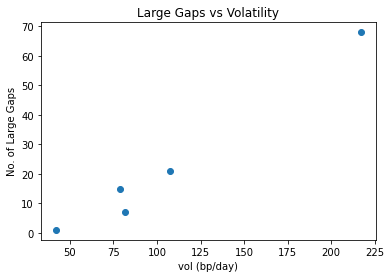


c:
      Year No. of Tdays No. of 75byGaps Fitted No. of 75bpGaps
      2021        238          7       7.12
      2020        253         68      70.59
      2019        252         15      11.42
      2018        251         21      15.98
      2017        251          1       6.88

d:
predict 2022: 19.87586
Pseudo R2: 0.97198
RMSE: 14.09565


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import PoissonRegressor

# Load data
df = pd.read_csv('data.csv')

# Data wrangling
df['Timestamp'] = pd.to_datetime(df['Date'])
df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
df.sort_values(by=['Timestamp'], inplace=True, ascending=False)
df['Return'] = df['Close'].pct_change(-1)*10000
df['Gap'] = (df['Open']/df['Close'].shift(-1)-1)*10000
df['Large_gap'] = abs(df['Gap'])
df['Large_gap'] = df['Large_gap'].apply(lambda x: 1 if x > 75 else 0)

# Calculate the metrics for part a
Year = [2017, 2018, 2019, 2020, 2021]
No_of_TDays = []
volatility = []
No_of_75bpGaps = []
for i in range(2017,2022):
    No_of_TDays.append(len(df[df['Year'] == i]))
    volatility.append(df[df['Year'] == i]['Return'].std())
    No_of_75bpGaps.append(len(df[(df['Year'] == i) & (df['Large_gap'] == 1)]))

# Print part a
print('a:')
print('{:>10} {:>10} {:>10} {:>10}'.format('Year', 'No. of Tdays', 'Volatility', 'No. of 75bpGaps'))
for i in range(4,-1,-1):
    print('{:>10} {:>10} {:>10} {:>10}'.format(Year[i],No_of_TDays[i],round(volatility[i],2),No_of_75bpGaps[i]))

# Plot No. of
print('\nb:')
plt.scatter(volatility, No_of_75bpGaps)
plt.xlabel('vol (bp/day)')
plt.ylabel('No. of Large Gaps')
plt.title('Large Gaps vs Volatility')
plt.show()

# Perform Poisson regression
y=No_of_75bpGaps
x=np.column_stack((No_of_TDays, volatility))
model = PoissonRegressor(alpha=0)
model.fit(x, y)
y_pred=model.predict(x)

# Print fitted values
print('\nc:')
print('{:>10} {:>10} {:>10} {:>10}'.format('Year', 'No. of Tdays', 'No. of 75byGaps', 'Fitted No. of 75bpGaps'))
for i in range(4,-1,-1):
    print('{:>10} {:>10} {:>10} {:>10}'.format(Year[i],No_of_TDays[i],No_of_75bpGaps[i],round(y_pred[i],2)))

# Prediction and evaluation
predict_2022 = model.predict([[252, 121.5]])
print('\nd:')
print('predict 2022:', np.array(predict_2022)[0].round(5))
def pseudo_r2(y_true, y_pred):
    SS_res =  np.sum((y_true - y_pred) ** 2)
    SS_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (SS_res / SS_tot)
pseudo_r2_score = pseudo_r2(y, y_pred)
print('Pseudo R2:', round(pseudo_r2_score,5))
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
rmse_record=[]
for i in range(2017,2022):
    if i == 2020:
        continue
    index=i-2017
    x_train=np.delete(x, index, 0).reshape(-1,2)
    y_train=np.delete(y, index, 0)
    x_test=np.array(x[index]).reshape(-1,2)
    y_test=np.array(y[index])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    rmse_record.append(rmse(y_pred, y_test))
print('RMSE:', np.array(rmse_record).mean().round(5))